In [1]:
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import time

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np
from itertools import combinations
from enum import Enum

In [4]:
from urdf_parser_py.urdf import URDF
from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE
from pkg.joint_utils import *
from pkg.ros_rviz import *

In [5]:
from pkg.tf_transform import *
from pkg.tf_robot import *
from pkg.constraint import *
from pkg.info import *
from pkg.tf_utils import *
from pkg.rotation_utils import *
from pkg.utils import *
from pkg.ur10 import *
from pkg.geometry import *
from pkg.collision import *
from pkg.distance import *
from pkg.distance_calculator import *
from pkg.binding_calculator import *
from pkg.graph_tf import *

In [6]:
from queue import PriorityQueue
from queue import Queue
import uuid

# Data types

In [7]:
class Scenario(Enum):
    single_object_single_robot = 0
    double_object_single_robot = 1
    single_object_dual_robot = 2
    assembly_3_piece = 3

class State(CompareInterface):
    def __init__(self, node, obj_pos_dict, Q):
        self.node = node
        self.obj_pos_dict = obj_pos_dict
        self.Q = Q
    
    def get_tuple(self):
        return (self.node, self.obj_pos_dict, self.Q)
    
    def copy(self):
        return State(self.node, self.obj_pos_dict, self.Q)
        
    def __str__(self):
        return str((self.node, 
                    {k: str(np.round(v, 3)) for k, v in self.obj_pos_dict.items()} if self.obj_pos_dict is not None else None,  
                    str(np.round(self.Q, 2)) if self.Q is not None else None))
    
class SearchNode(CompareInterface):
    def __init__(self, idx=None, state=None, redundancy=None, parents=None, leafs=None, leafs_P=None, depth=None, edepth=None):
        if idx is None:
            idx = uuid.uuid1().int
        if parents is None:
            parents = []
        if leafs is None:
            leafs = []
        if leafs_P is None:
            leafs_P = [1.0]*len(leafs)
        if depth is None:
            depth = len(parents)
        self.idx, self.state, self.redundancy, self.parents, self.leafs, self.leafs_P, self.depth, self.edepth = \
            idx, state, redundancy, parents, leafs, leafs_P, depth, edepth
        
    def make_child(self, state, edepth, **kwargs):
        child = SearchNode(state=state, parents=self.parents+[self.idx], depth=self.depth+1, 
                          edepth=edepth, **kwargs)
        self.add_leaf(child.idx)
        return child
    
    def add_leaf(self, leaf_idx, Pval=1.0):
        self.leafs += [leaf_idx]
        self.leafs_P += [Pval]
    
    def switch_parent(self, parent):
        self.parents = parent.parents+[parent.idx]
        depth_new = len(self.parents)
        self.edepth = self.edepth - (self.depth-depth_new)
        self.depth = depth_new
            
class Transition(CompareInterface):
    def __init__(self, snode_from, snode_to, wp_checked=[], wp_new=None):
        if not wp_checked:
            wp_checked = [snode_from]
        if wp_new is None:
            wp_new = snode_to
        self.snode_from, self.snode_to, self.__wp_checked, self.wp_new = \
                snode_from, snode_to, wp_checked, wp_new
        self.num_wp = len(wp_checked)
        
    def add_wp(self, snode):
        self.__wp_checked += [self.wp_new]
        self.num_wp += 1
        self.wp_new = snode
        
    def replace_wp(self, snode):
        self.wp_new = snode
    
    def get_wps(self):
        return self.__wp_checked
    
    def get_last_wp(self):
        return self.__wp_checked[-1]
        
    def get_tuple(self):
        return self.snode_from, self.snode_to, self.__wp_checked, self.wp_new

In [8]:
class RRTNode(CompareInterface):
    def __init__(self, state, parent=None, idx=None):
        if idx is None:
            idx = uuid.uuid1().int
        self.state, self.parent, self.leafs, self.bcosts, self.idx = state, parent, [], [], idx
        
    def set_idx(self, idx):
        self.idx = idx
    
    def attach(self, child, bcost):
        child.parent = self.idx
        self.reach(child, bcost)
        
    def reach(self, child, bcost):
        self.leafs.append(child.idx)
        self.bcosts.append(bcost)
        
    def detach(self, child_idx):
        i_ch = self.leafs.index(child_idx)
        self.leafs.pop(i_ch)
        self.bcosts.pop(i_ch)
    
class RRTGraph(CompareInterface):
## require all states inputs collision verified
    def __init__(self, root, goals, goal_names, svc_fun, rad=np.pi/2, idx=None):
        if idx is None:
            idx = uuid.uuid1().int
        self.idx = idx
        self.Qdim = len(root.Q)
        self.rad = rad
        self.node_counter = 0
        self.node_list = []
        self.config_mat = np.zeros((0,self.Qdim))
        self.cost_list = []
        self.svc_fun = svc_fun
        self.goal_counter = 0
        self.goal_list = []
        self.goal_config_mat = np.zeros((0,self.Qdim))
        for goal in goals:
            self.add_goal(goal)
        self.goal_names = goal_names
        self.add_node(root)
    
    def add_goal(self, state):
        gnode = RRTNode(state, idx=self.goal_counter)
        self.goal_list.append(gnode)
        self.goal_counter += 1
        self.goal_config_mat = np.concatenate([self.goal_config_mat, [state.Q]], axis=0)
        
    def attach_goal(self, goal_idx, node_idx):
        goal = self.goal_list[goal_idx]
        node = self.node_list[node_idx]
        bcost = self.calc_bcost(goal, node)
        goal.reach(node, bcost)

    
    def create_node(self, state, parent_idx=None, cost=inf):
        if parent_idx is None:
            cost=0
        rnode = RRTNode(state=state, idx=self.node_counter)
        self.node_list.append(rnode)
        self.node_counter += 1
        self.config_mat = np.concatenate([self.config_mat, [state.Q]], axis=0)
        self.cost_list.append(cost)
        if parent_idx is not None:
            self.attach(parent_idx, rnode.idx)
        return rnode
        
    def attach(self, parent_idx, child_idx):
        parent = self.node_list[parent_idx]
        child = self.node_list[child_idx]
        if child.parent is not None:
            self.node_list[child.parent].detach(child_idx)
        bcost = self.calc_bcost(parent, child)
        parent.attach(child, bcost)
        self.update_cost(child_idx, self.cost_list[parent_idx] + bcost)
        
    def calc_bcost(self, rnode1, rnode2):
        return np.linalg.norm(np.subtract(rnode1.state.Q, rnode2.state.Q))
        
    def update_cost(self, rnode_idx, newcost):
        rnode = self.node_list[rnode_idx]
        self.cost_list[rnode_idx] = newcost
        for leaf_idx, bcost in zip(rnode.leafs, rnode.bcosts):
            self.update_cost(leaf_idx, newcost + bcost)
            
    def add_node(self, state):
        branching_cost_vec = np.linalg.norm(np.subtract(self.config_mat, [state.Q]), axis=-1) # 0.035ms for 1000 node
        idx_near = np.where(branching_cost_vec<self.rad)[0]
        num_near = len(idx_near)
        res = self.svc_fun([self.node_list[idx].state for idx in idx_near]
                           +[goal.state for goal in self.goal_list], 
                           [state]*(num_near+self.goal_counter)
                          )
        idx_connect = [idx_near[i] for i in np.where(res[:num_near])[0]]
        idx_goal = [i for i in np.where(res[num_near:])[0]]
        cost_vec = np.add(self.cost_list, branching_cost_vec)[idx_connect]
        parent_idx = idx_connect[np.argmin(cost_vec)] if cost_vec.size>0 else None
        rnode = self.create_node(state=state, parent_idx=parent_idx)
        for ig in idx_goal:
            self.attach_goal(ig, rnode.idx)

In [9]:
gtimer = GlobalTimer()

In [10]:
def TestSVC(a, b):
    timer.sleep(10e-3)
    return [True]*len(a)
goals = [State(None, {}, [3,3]), State(None, {}, [1.5,1])]
goal_names = [1, 2]
gtimer.reset()
gtimer.tic("create")
rgraph = RRTGraph(State(None, {}, [0,0]), goals, goal_names, svc_fun = TestSVC)
gtimer.toctic("create","node")
rgraph.add_node(State(None, {}, [1,1]))
gtimer.toctic("node","node")
rgraph.add_node(State(None, {}, [1,2]))
gtimer.toctic("node","node")
rgraph.add_node(State(None, {}, [1,0]))
gtimer.toctic("node","node")
rgraph.add_node(State(None, {}, [1,0.5]))
gtimer.toctic("node","node")
rgraph.add_node(State(None, {}, [2,2.5]))
gtimer.toc("node")
print(gtimer)
from pkg.graph_visualize import VisualGraph
vgraph = VisualGraph()
for rnode, rcost in zip(rgraph.node_list, rgraph.cost_list):
    node_q = "{}-{}".format(tuple(rnode.state.Q), rcost)
    leaf_q = ["{}-{}".format(tuple(rgraph.node_list[leaf].state.Q), rgraph.cost_list[leaf]) for leaf in rnode.leafs]
    vgraph.add_node(node_q, leaf_q)
for gnode, gname in zip(rgraph.goal_list, rgraph.goal_names):
    node_q = "{}-g{}".format(tuple(gnode.state.Q), gname)
    leaf_q = ["{}-{}".format(tuple(rgraph.node_list[leaf].state.Q), rgraph.cost_list[leaf]) for leaf in gnode.leafs]
    vgraph.add_node(node_q, leaf_q)

# vgraph.draw(True)

create: 	11.0 ms/1 = 11.113 ms 
node: 	53.0 ms/5 = 10.518 ms 



In [11]:
class AutoPriorityQueue(PriorityQueue):
    def __init__(self, priority_fun, *args, **kwargs):
        self.priority_fun = priority_fun
        super(AutoPriorityQueue, self).__init__(*args, **kwargs)
    
    def put(self, value):
        super(AutoPriorityQueue, self).put((self.priority_fun(value), value))
        
    def get(self, *args, **kwargs):
        return super(AutoPriorityQueue, self).get(*args, **kwargs)[1]

# Constraint Graph

In [12]:

        
class ConstraintGraph:
    DEFAULT_TRANSIT_COST = 1.0
    DQ_MAX = np.deg2rad(90)
    DSCALE = 1e4

    def __init__(self, urdf_path,  joint_names, link_names):
        self.urdf_path = urdf_path
        self.urdf_content = URDF.from_xml_file(urdf_path)
        self.link_info_list = get_link_info_list(link_names, self.urdf_content)
        self.robot_info = RobotInfo(self.link_info_list, rname = "rbt0", base_frame=np.identity(4,dtype=np.float32))
        self.joint_names = joint_names
        self.link_names = link_names
        
    def set_items(self, gitem_list, gframe_dict):
        self.gitem_list = gitem_list
        self.gframe_dict = gframe_dict
        
        # prepare ros
        self.pub, self.joints, self.rate_ros = get_publisher(self.joint_names)
        # prepare visualization markers
        self.marker_list = set_markers(self.gitem_list, self.gframe_dict, self.urdf_content)
        show_motion([np.array([0]*6)], self.marker_list, 
                    [[gframe_dict[mk.geometry.name] for mk in self.marker_list]], 
                    self.pub, self.joints, error_skip=1e-6, period=1e-6)
        
    def show_state(self, gframe_dict=None):
        if gframe_dict is not None:
            self.gframe_dict = gframe_dict
        show_motion([np.array([0]*6)], self.marker_list, 
                    [[gframe_dict[mk.geometry.name] for mk in self.marker_list]], 
                    self.pub, self.joints, error_skip=1e-6, period=1e-6)
        
    def set_binding(self, binfo_list):
        self.binfo_list = binfo_list
        
    def set_simulation(self, N_sim, binfo_list=None, **kwargs):
        self.N_sim = N_sim
        if binfo_list is not None:
            self.set_binding(binfo_list)
        self.model = GraphModel(robot_info=self.robot_info, gitem_list=self.gitem_list, binfo_list=self.binfo_list, 
                           urdf_content=self.urdf_content, N_sim=self.N_sim, **kwargs)
        
    def update_handles(self):
        self.handle_dict = defaultdict(lambda: [])
        for k, v in self.model.binding_dict.items():
            if not v.btype.is_binder():
                self.handle_dict[v.obj_layer.name] += [k]
        self.object_list = [name for name in self.model.object_name_list if name in self.handle_dict]
        self.binder_list = [name for name in self.model.binding_name_list if self.model.binding_dict[name].btype.is_binder()]
        

    def get_unique_binders(self):
        uniq_binders = []
        for k_b, binder in self.model.binding_dict.items():
            if binder.btype.is_binder() and not binder.btype.is_multiple():
                uniq_binders += [k_b]
        return uniq_binders

    def get_controlled_binders(self):
        controlled_binders = []
        for k_b, binder in self.model.binding_dict.items():
            if binder.btype.is_binder() and binder.btype.is_controlled():
                controlled_binders += [k_b]
        return controlled_binders
    
    def build_graph(self):
        self.update_handles()
        self.node_dict = {}
        bindings = get_all_mapping(self.handle_dict.keys(), self.binder_list)
        handle_combinations = list(product(*[self.handle_dict[obj] for obj in self.object_list]))
        uniq_binders = self.get_unique_binders()
        ctrl_binders = self.get_controlled_binders()
        self.node_list = []
        self.node_dict = {}
        for binding in bindings:
            if all([np.sum([bd == ub for bd in  binding.values()])<=1 for ub in uniq_binders]):
                for hc in handle_combinations:
                    node = []
                    add_ok = True
                    for i_o, obj in zip(range(len(self.object_list)), self.object_list):
                        hndl_name = hc[i_o]
                        if self.model.bind_cal.pair_condition(self.model.binding_dict[binding[obj]], self.model.binding_dict[hndl_name]):
                            node += [(obj, hc[i_o], binding[obj]) ]
                        else:
                            add_ok = False
                    if add_ok:
                        node = tuple(node)
                        self.node_list += [node]
                        self.node_dict[node] = []
        for node in self.node_list:
            fixed_in = [i_n for i_n in range(len(node)) if node[i_n][2] not in ctrl_binders]
            ctrl_in = [i_n for i_n in range(len(node)) if node[i_n][2] in ctrl_binders]
            if ctrl_in:
                bd_fixed = [node[idx] for idx in fixed_in]
                bd_ctrl = [node[idx][2] for idx in ctrl_in]
                pt_ctrl = [node[idx][1] for idx in ctrl_in]
                obj_ctrl = [node[idx][0] for idx in ctrl_in]
                nodes_same_fix = [nd for nd in  self.node_list if [nd[idx] for idx in fixed_in] == bd_fixed]
                nodes_diff_ctrl = [nd for nd in  nodes_same_fix if [nd[idx][2] for idx in ctrl_in] != bd_ctrl]
                nodes_diff_pt = [nd for nd in  nodes_diff_ctrl if [nd[idx][1] for idx in ctrl_in] != pt_ctrl]
                nodes_neighbor = [nd for nd in  nodes_diff_pt if len(set([bd[2] for bd, bd0 in zip(nd, node) if bd!=bd0]).intersection(bd_ctrl))==0]
                self.node_dict[node] += nodes_neighbor
                for nd_n in nodes_neighbor:
                    self.node_dict[nd_n] += [node]

        for node in self.node_dict.keys():
            if node in self.node_dict[node]:
                self.node_dict[node].remove(node)
            self.node_dict[node] = list(set(self.node_dict[node]))
        
    def score_graph(self, goal_node):
        frontier = PriorityQueue()
        frontier.put(goal_node, 0)
        came_from = {}
        node_cost_dict = {}
        came_from[goal_node] = None
        node_cost_dict[goal_node] = 0

        while not frontier.empty():
            current = frontier.get()

            for next in self.node_dict[current]:
                if next == current:
                    continue
                new_cost = node_cost_dict[current] + ConstraintGraph.DEFAULT_TRANSIT_COST
                if next not in node_cost_dict or new_cost < node_cost_dict[next]:
                    node_cost_dict[next] = new_cost
                    priority = new_cost
                    frontier.put(next, priority)
                    came_from[next] = current
        return node_cost_dict
                  
    def check_goal(self, state, goal):
        return all([g is None or s==g for s,g in zip(state.get_tuple(), goal.get_tuple())])
    
    def get_valid_neighbor(self, node, margin=0):
        neighbor = self.node_dict[node]
        neighbor_valid = []
        for leaf in neighbor:
            if self.goal_cost_dict[leaf]<=self.goal_cost_dict[node]+margin:
                neighbor_valid += [leaf]
        return neighbor_valid

    def reset_valid_node(self, margin=0, node=None):
        if node == None:
            node = self.initial_state.node
            self.valid_node_dict = {self.goal_state.node:[]}
        if node == self.goal_state.node or node in self.valid_node_dict:
            return
        neighbor = self.get_valid_neighbor(node, margin=margin)
        if node in self.valid_node_dict and self.valid_node_dict[node] == neighbor:
            return
        self.valid_node_dict[node] = neighbor
        for leaf in neighbor:
            new_margin = margin - max(0, self.goal_cost_dict[leaf]-self.goal_cost_dict[node])
            new_margin = max(0, new_margin)
            if leaf != node and new_margin>=0:
                self.reset_valid_node(margin=new_margin, node=leaf)
        for k in self.valid_node_dict.keys():
            self.valid_node_dict[k].reverse()
            
            
    def get_link(self, oname, new_binding_dict, gframe_base):
        bindee_name = new_binding_dict[oname][0]
        binder_name = new_binding_dict[oname][1]
        bobj_name = self.model.binding_dict[binder_name].obj_layer.name
        if bobj_name in gframe_base:
            return gframe_base[bobj_name].link_name
        else:
            return self.get_link(bobj_name, new_binding_dict, gframe_base)

    def State2FrameDict(self, state):
        new_binding_dict = {bd[0]: (bd[1], bd[2]) for bd in state.node}
        gframe_base = {k:v for k, v in self.gframe_dict.items() if k not in new_binding_dict}
        new_gframe_dict = dict(self.gframe_dict)
        for oname in list(new_binding_dict.keys()):
            opos = state.obj_pos_dict[oname]
            oToff = SE3(Rotation.from_quat(opos[3:]).as_matrix(), opos[:3])
            obj_link = self.get_link(oname, new_binding_dict, gframe_base)
            new_gframe_dict[oname] = GeometryFrame(oToff, obj_link)
        return new_gframe_dict

    def FrameDict2State(self, gframe_dict, Q, state_ref):
        obj_pos_dict_new = {}
        for k in state_ref.obj_pos_dict.keys():
            Toff = gframe_dict[k].Toff
            Poff = Toff[:3, 3]
            Quat = Rotation.from_matrix(Toff[:3,:3]).as_quat()
            pos = np.concatenate([Poff, Quat], axis=-1)
            obj_pos_dict_new[k] = pos
        return State(state_ref.node, obj_pos_dict_new, Q)
    
    def get_slack_pairs(self, state, to_state):
        done = False
        slacks = []
        for bd, to_bd in zip(state.node, to_state.node):
            if bd != to_bd:
                slacks += [tuple(self.model.binding_index_dict[bname] for bname in to_bd[1:])]
                done = True
        Q = np.zeros((self.model.robot.DOF,), dtype=np.float32)
        Qmask = np.zeros((self.model.robot.DOF,), dtype=np.float32)
        if not done:
            Q = to_state.Q
            Qmask = np.ones((self.model.robot.DOF,), dtype=np.float32)
        return slacks, Q, Qmask
    
    def ProjectConfigBatch(self, from_state_list, to_state_list, N_loop=100, display=False, display_duration=1e-2, idx_show=0):
    #     gtimer.reset()
    #     gtimer.tic("convert")
        # convert
        gframe_dict_list = []
        Q_list = []
        Qtar_list = []
        Qmask_list = []
        slack_batch = []
        for state, to_state in zip(from_state_list, to_state_list):
            gframe_dict_list += [self.State2FrameDict(state)]
            Q_list += [state.Q]
            slacks, Qtar, Qmask = self.get_slack_pairs(state, to_state)
            slack_batch += [slacks]
            Qtar_list += [Qtar]
            Qmask_list += [Qmask]
        # fill rest
        N_rest = (self.model.N_sim-len(from_state_list))
        gframe_dict_list += [gframe_dict_list[-1]]*N_rest
        Q_list += [Q_list[-1]]*N_rest
        slack_batch += [slack_batch[-1]]*N_rest
        Qtar_list += [Qtar_list[-1]]*N_rest
        Qmask_list += [Qmask_list[-1]]*N_rest
        Q_mat = np.array(Q_list, dtype=np.float32)
        joint_batch = np.array(Qtar_list, dtype=np.float32)
        joint_mask_batch = np.array(Qmask_list, dtype=np.float32)
    #     gtimer.toc("convert")

    #     gtimer.tic("assign")
        self.model.assign_Q(Q_mat)
        self.model.assign_frame_dict(gframe_dict_list)
        self.model.set_slack_batch(slack_batch, joint_batch, joint_mask_batch)
    #     gtimer.toc("assign")

    #     gtimer.tic("step")
        if display:
            res, T_all, Tbo_all = self.model.run_test_disp(N_loop=N_loop, show_motion_func=self.show_motion, idx_show=idx_show)
            timer.sleep(display_duration)
        else:
            res, T_all, Tbo_all = self.model.run_test(N_loop=N_loop)
    #     gtimer.toc("step")

    #     gtimer.tic("revert")
        Qnew = self.model.get_Q().numpy()
        res = res.numpy()
        gframe_dict_list_new = self.model.update_slack_frames(gframe_dict_list, T_all, Tbo_all)
        new_state_list = []
        for i_s, gframe_dict, to_state in zip(range(self.model.N_sim), gframe_dict_list_new, to_state_list):
            new_state_list += [self.FrameDict2State(gframe_dict, Qnew[i_s], to_state)]
    #     gtimer.toc("revert")

        return new_state_list, res
    
    def show_motion(self, pose, gframeset):
        gframevec = [gframeset[mk.geometry.name] for mk in self.marker_list]
        gframevec_list = [gframevec]
        show_motion([pose], self.marker_list, gframevec_list, 
                    self.pub, self.joints, error_skip=1e-6, period=1e-6)
        
    def get_priority(self, snode):
        return snode.edepth*self.DSCALE-snode.depth
        
    def get_transition_priority(self, transition):
        return transition.wp_new.edepth*self.DSCALE-transition.wp_new.depth
        
    def get_expected_depth(self, snode, leaf=None):
        if leaf is None:
            return snode.depth+self.goal_cost_dict[snode.state.node]
        else:
            return snode.depth+1+self.goal_cost_dict[leaf]
    
    def add_snode(self, snode):
        snode.idx = self.snode_counter
        self.snode_vec += [snode]
        self.snode_counter += 1

    def add_snode_queue_leafs(self, snode):
        self.add_snode(snode)
        state = snode.state
        leafs = self.valid_node_dict[state.node]
        if len(leafs) == 0:
            return snode
        for leaf in leafs:
            depth = snode.depth+1
            expected_depth = depth+self.goal_cost_dict[leaf]
            if expected_depth>self.depth_max:
                continue
            to_state = state.copy()

            if leaf == state.node:
                dQ = (1-2*np.random.rand(self.DOF))*ConstraintGraph.DQ_MAX
                to_state.Q = np.sum([state.Q, dQ], axis=0)
            else:
                to_state.node = leaf
            snode_new = SearchNode(idx=-1, state=to_state, parents=snode.parents+[snode.idx], depth=depth, edepth=expected_depth)
            self.snode_queue.put((self.get_priority(snode), snode, snode_new))
        return snode
    
    def print_snode_list(self):
        for i_s, snode in zip(range(len(self.snode_vec)),self.snode_vec):
            print("{}{}<-{}{}".format(i_s, snode.state.node, snode.parents[-1] if snode.parents else "", self.snode_vec[snode.parents[-1]].state.node if snode.parents else ""))

    def quiver_snodes(self, figsize=(10,10)):
        import matplotlib.pyplot as plt
        N_plot = len(self.snode_vec)
        cost_vec = [self.goal_cost_dict[snode.state.node] for snode in self.snode_vec[1:N_plot]]
        parent_vec = [self.goal_cost_dict[self.snode_vec[snode.parents[-1]].state.node] for snode in self.snode_vec[1:N_plot]]
        plt.figure(figsize=figsize)
        X = list(range(1,N_plot))
        plt.quiver(X, parent_vec, 
                   [0]*(N_plot-1), 
                   np.subtract(cost_vec, parent_vec), 
                   angles='xy', scale_units='xy', scale=1)
        plt.plot(X, cost_vec,'.')
        plt.plot(X, parent_vec,'.')
        plt.axis([0,N_plot+1,-0.5,4.5])
        
    def find_schedules(self):
        self.idx_goal = []
        schedule_dict = {}
        for i in range(len(self.snode_vec)):
            snode = self.snode_vec[i]
            state = snode.state
            if self.check_goal(state, self.goal_state):
                self.idx_goal += [i]
                schedule = snode.parents + [i]
                schedule_dict[i] = schedule
        return schedule_dict

    def sort_schedule(self, schedule_dict):
        return sorted(schedule_dict.values(), key=lambda x: len(x))

    def replay(self, schedule, duration=1e-2, N_loop=100):
        for i_s in range(1, len(schedule)):
            self.simulate_transition_batch([self.snode_vec[schedule[i_s-1]].state], 
                                           [self.snode_vec[schedule[i_s]].state], 
                                           display=True,display_duration=duration, N_loop=N_loop)
            
    def add_snode_dict(self, snode):
        self.snode_dict[snode.idx] = snode
        return snode
    
    def SweptVolumeTestBatch(self, wp1_list, wp2_list):
        results = [True for _ in wp1_list]
        return results
            
    def RandomRedundancy(self, Nrd=1):
        assert Nrd == 1, "redundancy not implemented"
        return [0]
        
    def VerifyPutTransition(self, transition):
        # verification not implemented
        for wp in transition.get_last_wp():
            self.add_snode(wp)
        self.add_snode_queue_leafs(transition.get_last_wp())
    
    def BuildRRTGraph(self, proj_kwargs={}):
        snode = self.add_snode_dict(SearchNode(state=initial_state, edepth=depth_min))
        self.snode_queue.put(snode)
        node_dict = defaultdict(lambda:[])
        edge_queue = Queue()
        while not (self.snode_queue.empty() and edge_queue.empty()):
            snode = self.snode_queue.get()
            leafs = self.valid_node_dict[snode.state.node]
            for leaf in leafs:
                if leaf not in node_dict:
                    new_snodes = []
                    rrd = self.RandomRedundancy()
                    for rd in rrd:
                        state_new = snode.state.copy()
                        state_new.node = leaf
                        snode_new = snode.make_child(state=state_new, redundancy=rd, edepth=self.get_expected_depth(snode, leaf))
                        new_snodes += [snode_new]
                else:
                    new_snodes = node_dict[leaf]
                    for snode_new in new_snodes:
                        snode.add_leaf(snode_new.idx)
                    if new_snodes[0].depth > snode.depth+1:
                        for snode_new in new_snodes:
                            snode_new.switch_parent(snode)
                for snode_new in new_snodes:
                    edge_queue.put((snode, snode_new))
            if ((not edge_queue.empty()) and
                (edge_queue.qsize()>=self.N_sim or self.snode_queue.empty())):
                from_snode_list = []
                to_snode_list = []
                from_state_list = []
                to_state_list = []
                for _ in range(self.N_sim):
                    if edge_queue.empty():
                        break
                    from_snode, to_snode = edge_queue.get()
                    from_snode_list += [from_snode]
                    to_snode_list += [to_snode]
                    from_state_list += [from_snode.state]
                    to_state_list += [to_snode.state]
                new_state_list, res = self.ProjectConfigBatch(from_state_list, to_state_list, **proj_kwargs)
                for succ, from_snode, to_snode, new_state in zip(res, from_snode_list, to_snode_list, new_state_list):
                    if succ:
                        to_snode.state = new_state
                        if to_snode.state.node not in node_dict:
                            to_snode = self.add_snode_dict(to_snode)
                            self.snode_queue.put(to_snode)
                            node_dict[to_snode.state.node] += [to_snode]
                    else:
                        idx_remove = from_snode.leafs.index(to_snode.idx)
        for snode in self.snode_dict.values():
            self.transition_dict[snode.idx] = RRTGraph(snode.state,
                                                       [self.snode_dict[leaf].state for leaf in snode.leafs], 
                                                       snode.leafs, svc_fun=self.SweptVolumeTestBatch)


# Test

In [13]:
cgraph = ConstraintGraph(urdf_path = URDF_PATH, joint_names = JOINT_NAMES, link_names = LINK_NAMES)
gtimer = GlobalTimer()

In [14]:
gitem_list, gframe_dict= get_link_items_offsets(color=(0,1,0,0.5), display=False)
gitem_list += [
    GeometryItem(name='box1', gtype=GeoType.BOX, dims=[0.1,0.1,0.1], color=(0.3,0.3,0.8,1), display=True, collision=True),
    GeometryItem(name='floor', gtype=GeoType.PLANE, dims=[0.5,0.5,0.01], color=(0.6,0.6,0.6,1), display=True, collision=True),
    GeometryItem(name='wall', gtype=GeoType.BOX, dims=[0.7,0.05,0.2], color=(0.4,0.3,0.0,1), display=True, collision=True),
    GeometryItem(name='stepper', gtype=GeoType.BOX, dims=[0.15,0.15,0.3], color=(0.4,0.3,0.0,1), display=True, collision=True),
    GeometryItem(name='goal_disp', gtype=GeoType.BOX, dims=[0.1,0.1,1e-3], color=(0.8,0.0,0.0,1), display=True, collision=False)
]
gframe_dict.update({"box1":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,-0.2,0.06)), "world"),
                    "floor":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.5,-0.3,-0.00501)), "world"),
                    "wall":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.7,0.0,0.1)), "world"),
                    "stepper":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.4,0.4,0.15)), "world"),
                    "goal_disp":GeometryFrame(SE3(Rot_zyx(0,0,0),(0.4,0.4,0.3)), "world")
                   })
binfo_list = [
    BindingInfo(
        name='vac1', btype=BindingType.VACC, obj_name='tool_mesh', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,0), (0,0,0.05))), 
    BindingInfo(
        name='goal', btype=BindingType.PLANE, obj_name='stepper', gtype=GeoType.SPHERE, Toff=SE3(Rot_zyx(0,0,np.pi), (0,0,0.151))), 
    BindingInfo(
        name='floortop', btype=BindingType.PLANE, obj_name='floor', gtype=None, Toff=SE3(Rot_zyx(0,0,np.pi), (0,0,0.01)))]

binfo_list += get_box_binding(get_by_name(gitem_list, "box1"))

In [15]:
cgraph.set_items(gitem_list, gframe_dict)
cgraph.set_binding(binfo_list)
cgraph.show_state(gframe_dict)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
publication OK - tool_mesh
publication OK - box1
publication OK - floor
publication OK - wall
publication OK - stepper
publication OK - goal_disp


In [47]:
cgraph.set_simulation(N_sim=32, dQ_max = tf.constant([[1.0]*6])*1e-1, COL_AVOID_MULTIPLIER=1)

In [48]:
cgraph.build_graph()
# for k,v in cgraph.node_dict.items():
#     print(k)
#     print(v)
#     print("="*100)

# Dev Semi-Lazy Collision Checking

In [49]:
self = cgraph
initial_state=State((('box1','box1-bottom','floortop'),), {'box1': [0.5,-0.2,0.1,0,0,0,1]}, ZERO_JOINT_POSE)
goal_state=State((('box1','box1-bottom','goal'),), None, None)
display=False
terminate_on_first=True
tree_margin=2
depth_margin=2
joint_motion_num=10
N_search = 100
verbose = True
N_loop=100
# def SearchGraphLazy(self, initial_state, goal_state, display=False, 
#                  terminate_on_first = True, tree_margin = 0, depth_margin = 0, joint_motion_num=10, 
#                  N_search = 100, verbose = False, N_loop=100):

In [50]:
self.joint_motion_num = joint_motion_num
self.t0 = timer.time()
self.DOF = len(initial_state.Q)
self.initial_state = initial_state
self.goal_state = goal_state

self.init_cost_dict, self.goal_cost_dict = self.score_graph(initial_state.node), self.score_graph(goal_state.node)
self.reset_valid_node(tree_margin)
depth_min = self.goal_cost_dict[initial_state.node]
self.depth_max = depth_min + depth_margin
self.snode_dict = dict()
self.snode_queue = AutoPriorityQueue(priority_fun=self.get_priority)
self.transition_dict = {}
self.verify_queue = AutoPriorityQueue(priority_fun=self.get_transition_priority)
self.verified_edges = Queue()
self.stop_iteration = False

In [51]:
gtimer.reset()
gtimer.tic("rrt")
self.BuildRRTGraph()#proj_kwargs=dict(display=True, display_duration=1e-1, idx_show=0))
gtimer.toc("rrt")
print(gtimer)

rrt: 	1528.0 ms/1 = 1528.066 ms 



In [52]:
self.transition_dict

{110404931624894137820182554494931434249: <__main__.RRTGraph at 0x7feb787c7eb8>,
 110404931704122300334446892088475384585: <__main__.RRTGraph at 0x7feb787c7c50>,
 111461612681697759000891792933913230089: <__main__.RRTGraph at 0x7feb787c7ba8>,
 111461612760925921515156130527457180425: <__main__.RRTGraph at 0x7feb787c7d30>}

In [ ]:
def SweptVolumeTestBatch(self, wp1_list, wp2_list):
    results = [True for _ in wp1_list]
    return results

In [36]:
   
def SweptVolumeTestBatch(self, wp1_list, wp2_list):
    results = [True for _ in wp1_list]
    return results

def VerifyPutTransition(self, transition):
    # verification not implemented
    for wp in transition.get_last_wp():
        self.add_snode(wp)
    self.add_snode_queue_leafs(transition.get_last_wp())

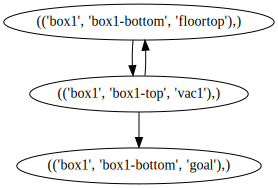

In [73]:

from pkg.graph_visualize import VisualGraph
vgraph = VisualGraph()
for k, v in cgraph.snode_dict.items():
    node_q = v.state.node
    leaf_q = [goal.state.node for goal in cgraph.transition_dict[k].goal_list]
    vgraph.add_node(node_q, leaf_q)
vgraph.draw(True)

# Dev search graph

In [ ]:
ZERO_JOINT_POSE = np.array([-1, -np.pi*0.6 , np.pi*0.6,-np.pi/2,-np.pi/2,0])

In [ ]:
gtimer.reset()
gtimer.tic("search")
cgraph.search_graph(initial_state=State((('box1','box1-bottom','floortop'),), {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE), 
             goal_state=State((('box1','box1-bottom','goal'),), None, None), display=False, 
                 terminate_on_first=True, tree_margin=0, depth_margin=2, joint_motion_num=10, 
                 N_search = 100, verbose = True, N_loop=100)
gtimer.toc("search")
print(gtimer)

In [ ]:
cgraph.quiver_snodes()
# cgraph.print_snode_list()

In [ ]:
schedule_dict = cgraph.find_schedules()
schedule_sorted = cgraph.sort_schedule(schedule_dict)
for schedule in schedule_sorted:
    print(schedule)
    cgraph.replay(schedule,0.1, N_loop=100)

In [ ]:
cgraph.show_motion(ZERO_JOINT_POSE, gframe_dict)


# Test time

In [ ]:
N_all = (2**np.arange(11)).tolist()
gtimer = GlobalTimer()
gtimer.reset()
for N_sim in N_all:
    gtimer.tic("initialize-{}".format(N_sim))
    cgraph.set_simulation(N_sim=N_sim, dQ_max = tf.constant([[1.0]*6])*1e-1, COL_AVOID_MULTIPLIER=1)
    cgraph.build_graph()
    cgraph.search_graph(initial_state=State((('box1','box1-bottom','floortop'),), {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE), 
                 goal_state=State((('box1','box1-top','vac1'),), None, None), display=False, 
                     terminate_on_first=True, tree_margin=0, depth_margin=2, joint_motion_num=10, 
                     N_search = 100, verbose = True, N_loop=100)
    gtimer.toc("initialize-{}".format(N_sim))
    gtimer.tic("search-{}".format(N_sim))
    cgraph.search_graph(initial_state=State((('box1','box1-bottom','floortop'),), {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE), 
                 goal_state=State((('box1','box1-top','vac1'),), None, None), display=False, 
                     terminate_on_first=True, tree_margin=0, depth_margin=2, joint_motion_num=10, 
                     N_search = 100, verbose = True, N_loop=100)
    gtimer.toc("search-{}".format(N_sim))
    print("="*100)
    print("="*40+"done: {}".format(N_sim)+"="*40)
print(gtimer)

In [ ]:
time_vec = [gtimer.time_dict["search-{}".format(N_s)] for N_s in N_all]

# saved plot: CPU case

In [ ]:
N_plot = 10
plt.figure(figsize=(15,7))
ax = plt.subplot(1,2,1)
ax.set_xscale("log", nonposx='clip')
ax.plot([0]+N_all[:N_plot], [0]+time_vec[:N_plot],'-o')
plt.xlabel("Simulation Num")
plt.ylabel("x 100 loop Time(ms)")
plt.grid()
ax = plt.subplot(1,2,2)
ax.set_xscale("log", nonposx='clip')
ax.plot(N_all[:N_plot], np.divide(N_all[:N_plot],time_vec[:N_plot])*1000,'-o')
plt.xlabel("Simulation Num")
plt.ylabel("Simulation Per Sec")
plt.grid()
np.savetxt("cpu_N_all_normed.csv", N_all, delimiter=',')
np.savetxt("cpu_time_vec_normed.csv", time_vec, delimiter=',')

# saved plot: GPU case

In [ ]:
N_plot = 18
plt.figure(figsize=(15,7))
ax = plt.subplot(1,2,1)
ax.set_xscale("log", nonposx='clip')
ax.plot([0]+N_all[:N_plot], [0]+time_vec[:N_plot],'-o')
plt.xlabel("Simulation Num")
plt.ylabel("x 100 loop Time(ms)")
plt.grid()
ax = plt.subplot(1,2,2)
ax.set_xscale("log", nonposx='clip')
ax.plot(N_all[:N_plot], np.divide(N_all[:N_plot],time_vec[:N_plot])*1000,'-o')
plt.xlabel("Simulation Num")
plt.ylabel("Simulation Per Sec")
plt.grid()
np.savetxt("gpu_N_all_normed.csv", N_all, delimiter=',')
np.savetxt("gpu_time_vec_normed.csv", time_vec, delimiter=',')

# Draw saved all

In [ ]:
cpu_N_all = np.loadtxt("cpu_N_all_normed.csv", delimiter=',')
cpu_time_vec = np.loadtxt("cpu_time_vec_normed.csv", delimiter=',')
gpu_N_all = np.loadtxt("gpu_N_all_normed.csv",  delimiter=',')
gpu_time_vec = np.loadtxt("gpu_time_vec_normed.csv", delimiter=',')

In [ ]:
N_eta = np.load('numbers-Copy1.npy')
iter_eta = np.load('iterations-Copy1.npy')
time_eta = np.load('times-Copy1.npy')

In [ ]:
plt.figure(figsize=(15,6))
ax = plt.subplot(1,2,1)
# ax.set_xscale("log", nonposx='clip')
ax.loglog(np.pad(cpu_N_all, [[1,0]]), np.pad(cpu_time_vec, [[1,0]]),'-o')
ax.loglog(np.pad(gpu_N_all, [[1,0]]), np.pad(gpu_time_vec, [[1,0]]),'-o')
plt.xlabel("Batch size")
plt.ylabel("x 100 loop Time(ms)")
plt.legend(["cpu-tensorflow", "gpu-tensorflow"])
plt.grid()
ax = plt.subplot(1,2,2)
# ax.set_xscale("log", nonposx='clip')
ax.loglog(cpu_N_all, np.divide(cpu_N_all,cpu_time_vec)*1000,'-o')
ax.loglog(gpu_N_all, np.divide(gpu_N_all,gpu_time_vec)*1000,'-o')
# ax.loglog(N_eta, np.divide(iter_eta,time_eta),'-.')
ax.loglog([1, 1e4], [100,100],'-.')
plt.xlabel("Batch size")
plt.ylabel("Simulation Per Sec")
plt.legend(["cpu-tensorflow", "gpu-tensorflow", "eTaSL"])
plt.grid()